# Gyro integrating model

This model is an evolution of the simple model, where we don't assume that we have access to a Digital Motion Processor (DMP) unit inside of the IMU. Instead, we will have to do the integral of the movement ourselves.

Here are our assumptions:

1. The robot moves in the 2D plane.
2. The gyroscope is in the yaw axis.
3. The gyroscope's output has a constant bias ($b_{\omega}$) and some white gaussian noise.
4. The robot starts its integration with a heading of $\theta = 0$.

The state of the robot is the following:

\begin{equation}
\mathbf{x} = \begin{pmatrix}
    x\\
    y\\
    \dot{x}\\
    \dot{y}\\
    \theta\\
    b_{\omega}
    \end{pmatrix}
\end{equation}

We include the bias in the state even if we cannot measure it.
This allows the model to take into account the variance of the bias in the prediction step.

## Future work
* How can we measure "real" yaw from the UWB output?
* Can we use the magnetometer output as a "real" yaw measurement?

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sp.init_printing()

# defines useful variables
x, y, xdot, ydot, theta, b_omega = sp.symbols('x y v_x v_y theta b_{\omega}')
state = sp.Matrix([x, y, xdot, ydot, theta, b_omega])
dt = sp.symbols('Delta_t')

## Prediction step

The prediction step uses outputs of the accelerometer (in body frame) and the angular rate as control inputs:

\begin{equation}
\mathbf{u} = \begin{pmatrix}
    a_x\\
    a_y\\
    \omega
\end{pmatrix}
\end{equation}

The differential equation governing the state evolution is therefore:

\begin{equation}
\mathbf{\dot{x}} = \begin{pmatrix}
\dot{x}\\
\dot{y}\\
\cos(\theta) a_x - \sin(\theta) a_y \\
\sin(\theta) a_x + \cos(\theta) a_y \\
\omega - b_{\omega}\\
0
\end{pmatrix}
\end{equation}

Using forward Euler integration we get:

\begin{equation}
\mathbf{x}_{k+1} = \mathbf{x}_{k} + \Delta_t \mathbf{\dot{x}} = \mathbf{g}\left(\mathbf{x}_{k}, \mathbf{u}_k\right)
\end{equation}

In [2]:
a_x, a_y, omega = sp.symbols('a_x a_y omega') # in body frame
u = [a_x, a_y, omega]
dx = sp.Matrix([xdot,
                ydot,
                sp.cos(theta) * a_x - sp.sin(theta) * a_y,
                sp.sin(theta) * a_x + sp.cos(theta) * a_y,
                omega - b_omega,
                0])
g = state + dt * dx

## Measurement step

For the measurement, the UWB system gives us the distance $d$ to a beacon.
The beacon's position $\mathbf{b}$ is known and assumed to be fixed.
Therefore the measurement model becomes:

\begin{equation}
h(\mathbf{x}, \mathbf{b}) = \sqrt{(x - b_x)^2 + (y - b_y)^2}
\end{equation}

In [3]:
b_x, b_y = sp.symbols('b_x b_y')
h = sp.Matrix([sp.sqrt((x - b_x)**2 + (y - b_y)**2)])

## Extended Kalman Filter

For this model we will use an Extended Kalman Filter to fuse the sensor's data.
The Extended Kalman filter requires us to compute the Jacobian of the update and measurement functions:

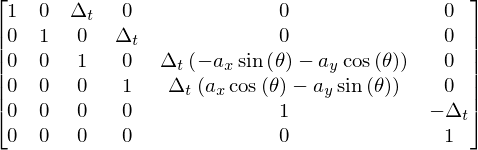

In [4]:
g.jacobian(state)

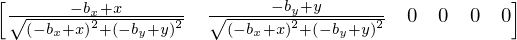

In [5]:
h.jacobian(state)

## Simulation

We can now implement the EKF using the framework we developped in `ekf.py`.
The functions we generated as Sympy expression will need to be slightly wrapped to fit the expected format.

In [6]:
f = 200 # Hz, sample rate of the filter
g_num = sp.lambdify([state, u], g.replace(dt, 1/f), 'numpy')
G_num = sp.lambdify([state, u], g.jacobian(state).replace(dt, 1/f), 'numpy')
h_num = sp.lambdify([[b_x, b_y], state], h, 'numpy')
H_num = sp.lambdify([[b_x, b_y], state], h.jacobian(state), 'numpy')

In [7]:
# Quick check that the forward equation looks correct
mu = g_num([0,0,1,2,0,0.3], [1,0,1])
assert mu[0] == 0.005
assert mu[2] == 1.005
assert mu[4] == 0.0035
assert mu[5] == 0.3

In [8]:
# Defines the kalman filter
import functools
import ekf

# Create a dummy variance model
R = np.diag([0.1, # pos
             0.1,
             1e-4, # speed
             1e-4,
             1e-4, # angle
             1e-4  # bias
            ])
Q = np.diag([0.1]) # distance measurement

predictor = ekf.Predictor(g_num, G_num, R)

BEACON_POS = [
    (-1.5, 0),
    (1.5, 1),
    (1.5, -1),
]
    
correctors = [
    ekf.Corrector(functools.partial(h_num, pos),
                  functools.partial(H_num, pos),
                  Q
                 )
for pos in BEACON_POS]

In [9]:
# Runs the kalman filter on a circular trajectory
import trajectories

f_uwb = 10 # Update frequency for the UWB beacons


bias = np.deg2rad(5) # rad / s
bias_var = np.deg2rad(10)

mu = np.array([0, 1, 0, 0.1, 0, bias]) # initial state
sigma = np.diag([1e-1, 1e-1, # pos
                 1e-3, 1e-3, # speed
                 1e-1, # angle
                 bias_var,
                ])

angle, angle_estimated = [], []
x, xhat = [], []
y, yhat = [], []
acc = []
ts = []

for i, p in zip(range(10000), trajectories.generate_circular_traj(1, np.deg2rad(20), 1/f)):
    # add noise & bias to the measurements
    acc = [p.acc[0], p.acc[1]] + np.random.normal(0, 0.2, 2)
    omega = p.omega + bias + np.random.normal(0, bias_var)
    
    # feeds the input into Kalman
    filter_input = np.array([acc[0], acc[1], omega])
    mu, sigma = predictor(mu, sigma, filter_input)
    
    # If we received a radio update, feed it into the EKF
    if i % (f // f_uwb) == 0:
        for corrector, (bx, by) in zip(correctors, BEACON_POS):
            z = corrector.h(np.array([p.pos[0], p.pos[1], 0, 0, 0, 0]))
            z += np.random.normal(0, 0.1)
            mu, sigma = corrector(mu, sigma, z)
            
    
    # Saves the data
    ts.append(p.timestamp)
    angle.append(p.theta)
    angle_estimated.append(mu[4])
    x.append(p.pos[0])
    xhat.append(mu[0])
    y.append(p.pos[1])
    yhat.append(mu[1])

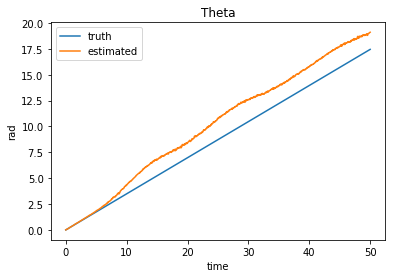

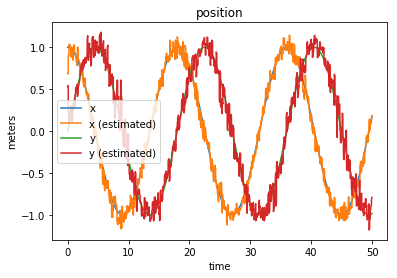

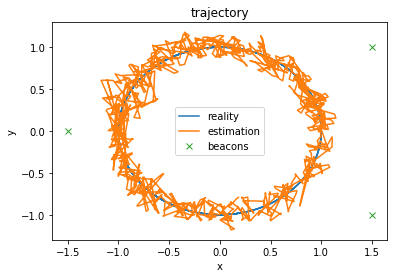

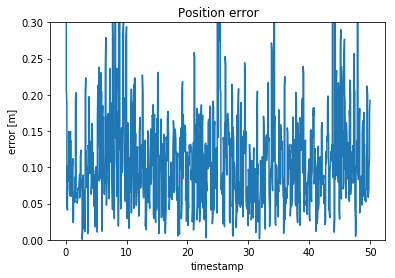

In [10]:
# Plot various results
plt.plot(ts, angle)
plt.plot(ts, angle_estimated)
plt.xlabel('time')
plt.ylabel('rad')
plt.legend(['truth', 'estimated'])
plt.title('Theta')
plt.show()

plt.plot(ts, x)
plt.plot(ts, xhat)
plt.plot(ts, y)
plt.plot(ts, yhat)
plt.xlabel('time')
plt.ylabel('meters')
plt.title('position')
plt.legend(['x', 'x (estimated)', 'y', 'y (estimated)'])
plt.show()

plt.plot(x, y)
plt.plot(xhat, yhat)
plt.plot([x for x, y in BEACON_POS],[y for x, y in BEACON_POS], 'x')
plt.legend(('reality', 'estimation', 'beacons'))
plt.title('trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.plot(ts, [np.sqrt((x-xh)**2+(y-yh)**2) for x,xh,y,yh in zip(x, xhat,y,yhat)])
plt.xlabel('timestamp')
plt.ylabel('error [m]')
plt.ylim(0, 0.3)
plt.title('Position error')
plt.show()